## First Steps with GeoPandas

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd

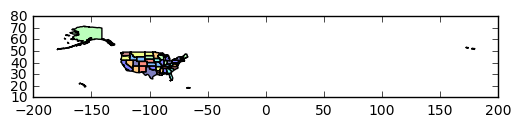

In [2]:
geo_df = gpd.read_file("data/cb_2015_us_state_20m.shp")
geo_df.plot()

In [3]:
geo_df.set_index(geo_df["STATEFP"].astype(int), inplace = True)
geo_df.head(5)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
STATEFP,,,,,,,,,,
48,0400000US48,676634395761,19027462392,48,00,Texas,48,01779801,TX,"POLYGON ((-106.623445 31.914034, -106.630114 3..."
6,0400000US06,403488955894,20477992907,06,00,California,06,01779778,CA,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
21,0400000US21,102266253024,2389483091,21,00,Kentucky,21,01779786,KY,"POLYGON ((-89.544434 36.57451, -89.47934599999..."
13,0400000US13,149169759045,4740824950,13,00,Georgia,13,01705317,GA,"POLYGON ((-85.605165 34.984678, -85.4743388431..."
55,0400000US55,140269484183,29365442607,55,00,Wisconsin,55,01779806,WI,"(POLYGON ((-86.934276 45.421149, -86.835748999..."


In [4]:
contiguous =  (geo_df.index < 57)
contiguous &= (geo_df.index != 15)
contiguous &= (geo_df.index != 2)
geo_df = geo_df[contiguous]

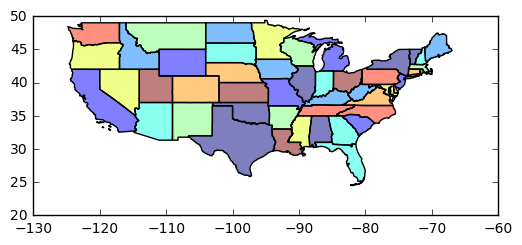

In [5]:
geo_df.plot()

{'init': 'epsg:4269'}


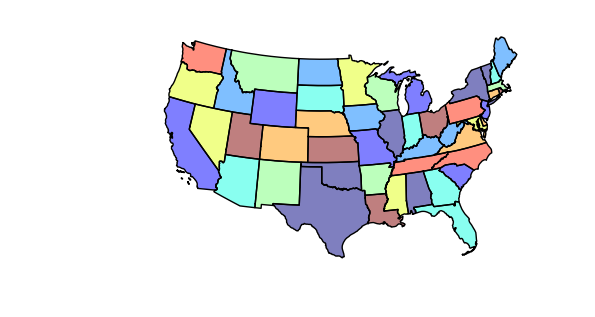

In [6]:
print(geo_df.crs)

# try 2163 (albers), 3857 (web), 4269 (plate)
ax = geo_df.to_crs(epsg=2163).plot()
ax.set_axis_off()

## Single Mothers by State

Download and format the state-by-state data; format the dataframe.  Set the State ID as the index as an integer, and rename the data column and cast it as a float.

In [7]:
import requests, pandas as pd
j = requests.get("http://api.census.gov/data/2014/acs5/profile?for=state:*&get=DP02_0037PE").json()
smom_df = pd.DataFrame(j[1:], columns = j[0])
smom_df["state"] = smom_df["state"].astype(int)
smom_df.set_index("state", inplace = True)
smom_df["DP02_0037PE"] = smom_df["DP02_0037PE"].astype(float)
smom_df.rename(columns = {"DP02_0037PE" : "Percent Mothers Unmarried"}, inplace = True)
smom_df.head()

,Percent Mothers Unmarried
state,
1,41.7
2,34.2
4,39.7
5,37.7
6,33.2


In [8]:
geo_merge = geo_df.join(smom_df, how = "inner")

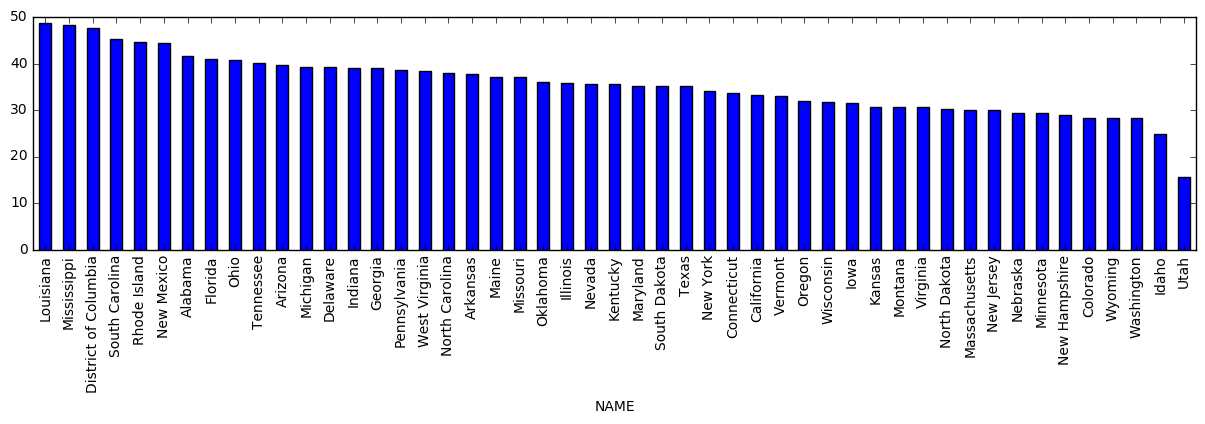

In [9]:
geo_merge.set_index("NAME")["Percent Mothers Unmarried"].sort_values(ascending = False).plot(kind = "bar", figsize = (15, 3))

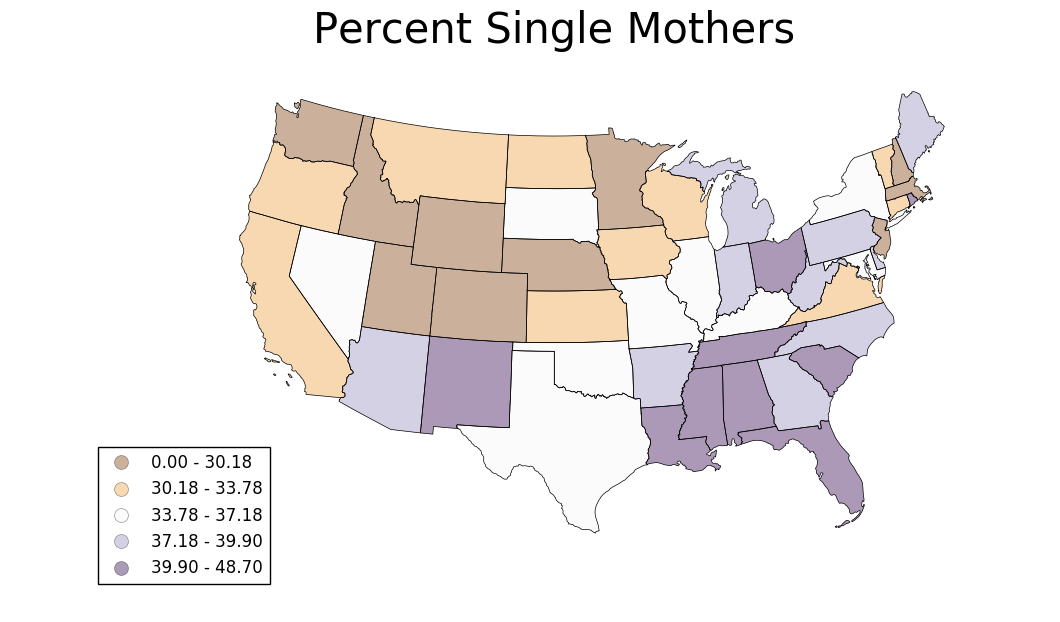

In [10]:
ft = "Percent Mothers Unmarried"

albers = geo_merge.to_crs(epsg=2163)
ax = albers.plot(column = ft, scheme = "quantiles", k = 5, cmap = "PuOr", legend = True,
                 alpha = 0.4, linewidth = 0.5, figsize = (12, 8))

ax.set_title("Percent Single Mothers", fontsize = 30)
ax.set_axis_off()

## Pennsylvania Election Returns

* Import pandas and geopandas, and the democratic vote shares from the last election.
* See `Advanced.ipynb` for the (not actually very advanced) scraping from the PA elections site.

In [ ]:
import pandas as pd, geopandas as gpd

demvote_df = pd.read_csv("pa_demshare.csv", index_col = "county")
demvote_df.head()

In [ ]:
counties = gpd.read_file("data/cb_2015_us_county_20m.shp")
counties["lname"] = counties["NAME"].str.lower()
counties = counties[counties["STATEFP"] == "42"].set_index("lname")

In [ ]:
merged = counties.join(demvote_df, how = "inner")

In [ ]:
ax = counties.plot()
ax.set_axis_off()

* Let's again make a Choropleth map, this time with `equal_interval`.
* This time, an appropriate CRS is 3651, for southern Pennsylvania ([spatial reference](http://spatialreference.org/ref/epsg/3651/)).

In [ ]:
ft = "Democratic Two-Party Vote Share"
ax = merged.to_crs(epsg = 3651).plot(scheme = "EQUAL_INTERVAL", k = 9, column = ft, 
                                     figsize = (23, 12), legend = True, cmap = "rainbow")
ax.set_axis_off()

Here, as above, we download data frome the census.  This time, it's the percent of adults with a bachelor's degree, at the county level.

In [ ]:
import requests, pandas as pd
j = requests.get("http://api.census.gov/data/2014/acs5/profile?for=county:*&in=state:42&get=NAME,DP02_0067PE").json()
educ_df = pd.DataFrame(j[1:], columns = j[0])
educ_df["county"] = educ_df["NAME"].str.lower()
educ_df["county"] = educ_df["county"].str.replace(" county, pennsylvania", "")
educ_df.set_index("county", inplace = True)
educ_df["DP02_0067PE"] = educ_df["DP02_0067PE"].astype(float)
educ_df.rename(columns = {"DP02_0067PE" : "Bachelor's Degree"}, inplace = True)
educ_df.head()

### Merge and Plot Bachelor's v. Share
Note again, the merging key is fundamentally geographical, though we're doing it with attributes.

In [ ]:
merged = demvote_df.join(educ_df, how = "inner")
merged.plot(kind = "scatter", x = "Democratic Two-Party Vote Share", y = "Bachelor's Degree")

# Spatial Joins

### Census Tracts
Import the tracts for chicago

In [6]:
tract_df = gpd.read_file("data/cb_2014_17_tract_500k.shp")
tract_df = tract_df[tract_df["COUNTYFP"] == "031"]

* Take a look at `first_degree_murders.csv`.
* There is no "geometry" column, but there _are_ latitudes and longitudes.
* Import it, and make the geometry.

In [7]:
from shapely.geometry import Point

crime_df = pd.read_csv("first_degree_murders.csv", usecols = [19, 20])
crime_df.dropna(inplace = True)

geometry = [Point(xy) for xy in zip(crime_df.Longitude, crime_df.Latitude)]
crime_coords = gpd.GeoDataFrame(crime_df, crs = tract_df.crs, geometry=geometry)

located_crimes = gpd.sjoin(crime_coords, tract_df, how = 'left', op = 'within')

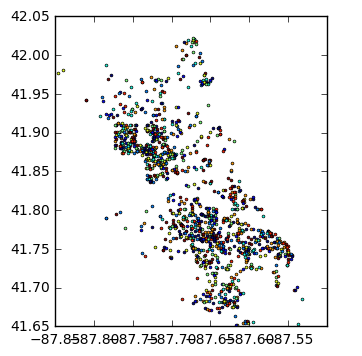

In [8]:
located_crimes.plot()

In [9]:
located_crimes.rename(columns = {"NAME" : "Census Tract", "index_right" : "Murders"}, inplace = True)

murder_tract_count = located_crimes.groupby("Census Tract").count()[["Murders"]]

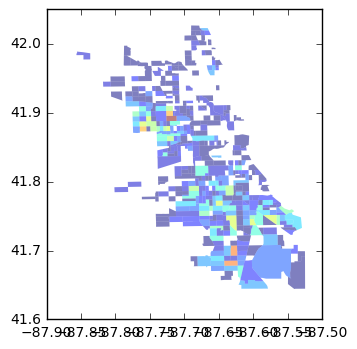

In [10]:
mapped_murders = pd.merge(tract_df, murder_tract_count, how = "inner", left_on = "NAME", right_index = True)
mapped_murders.plot(column = "Murders", k = 9, linewidth = 0)

### Again with Community Areas

In [11]:
commu_df = gpd.read_file("community_areas.geojson")

In [12]:
crime_coords = gpd.GeoDataFrame(crime_df, crs = commu_df.crs, geometry=geometry)
located_crimes = gpd.tools.sjoin(crime_coords, commu_df, how = 'left', op = 'within')

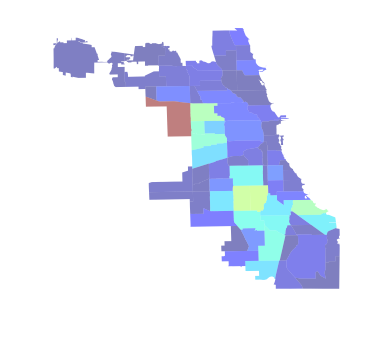

In [13]:
located_crimes.rename(columns = {"index_right" : "Murders"}, inplace = True)
murder_area_count = located_crimes.groupby("community").count()[["Murders"]]

mapped_murders = pd.merge(commu_df, murder_area_count, how = "inner", left_on = "community", right_index = True)
ax = mapped_murders.plot(column = "Murders", k = 9, linewidth = 0)

ax.set_axis_off()

## Interactive Web Maps!?  AWESOME!!!

In [11]:
import folium

m = folium.Map([39.828175, -98.5795], 
               tiles='cartodbpositron', 
               zoom_start=4, max_zoom=14, min_zoom=4)

ft = "Percent Mothers Unmarried"
cmap = folium.colormap.linear.YlOrRd.scale(geo_merge[ft].min(), geo_merge[ft].max())

folium.GeoJson(geo_merge,
               style_function=lambda feature: {
                'fillColor': cmap(feature['properties'][ft]),
                'fillOpacity' : 0.6,
                'weight' : 2, 'color' : 'black'
               }).add_to(m)

cmap.caption = 'Percent Children Born to Single Mothers'
cmap.add_to(m)

m.save("us_single_mothers.html")
m

In [18]:
from IPython.display import HTML, display

m._build_map()
mapWidth, mapHeight = (400,500) # width and height of the displayed iFrame, in pixels
srcdoc = m.HTML.replace('"', '&quot;')
embed = HTML('<iframe srcdoc="{}" '
             'style="width: {}px; height: {}px; display:block; width: 50%; margin: 0 auto; '
             'border: none"></iframe>'.format(srcdoc, width, height))
embed


AttributeError: 'Map' object has no attribute '_build_map'

## Spatial Associations and Geocoding

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("6021 S. Kimbark Ave, Chicago")
location

In [ ]:
from shapely.geometry import Point
pt = Point(-87.5940494865461, 41.7851555)

In [ ]:
state_df = gpd.read_file("data/cb_2015_us_state_20m.shp")
state_df[state_df.contains(pt)]["NAME"]

In [ ]:
tract_df = gpd.read_file("data/cb_2014_17_tract_500k.shp")
tract_df = tract_df[tract_df["COUNTYFP"] == "031"]
tract_df.head()

In [ ]:
geo_df[geo_df.contains(pt)]["NAME"]

## Mountain Maps

In [2]:
import geopandas as gpd, folium

m = folium.Map([39.828175, -98.5795], tiles='stamenwatercolor', zoom_start = 1)

df = gpd.read_file("TM_WORLD_BORDERS_SIMPL-0.3.shp")

mountains = ["Aconcagua", "Mount Kosciuszko", "Mont Blanc, Chamonix", "Mount Everest", "Denali", "Mount Elbrus", "Puncak Jaya", "Mount Kilimanjaro", "Mount Vinson"]
mtn_df = gpd.tools.geocode(mountains, provider = "googlev3").to_crs(df.crs)

folium.GeoJson(gpd.sjoin(df, mtn_df, how = "inner", op = "contains"),
               style_function=lambda feature: {
                'fillColor': 'red', 'fillOpacity' : 0.6, 'weight' : 2, 'color' : 'black'
               }).add_to(m)

for xi, pt in mtn_df.iterrows():
    folium.RegularPolygonMarker(pt.geometry.coords[::][0][::-1], popup=pt.address, 
                        number_of_sides = 5, radius = 8, fill_color = "black", fill_opacity = 1.0).add_to(m)

m

OSError: no such file or directory: 'TM_WORLD_BORDERS_SIMPL-0.3.shp'